In [4]:
import pyupbit
import pandas as pd
from datetime import datetime, timedelta

# ================== Í∞í ÏÑ§Ï†ï ==================
TICKERS = ["KRW-SOL", "KRW-ETH", "KRW-XRP", "KRW-DOGE", "KRW-USDT"]
INTERVAL = "minute60"               # 1ÏãúÍ∞ÑÎ¥â
BOT_INTERVAL = 15                   # Ïã§Ìñâ Ï£ºÍ∏∞ (Î∂Ñ Îã®ÏúÑ)
START_DATE = "2025-08-10"
END_DATE = "2025-08-26"
RSI_PERIOD = 14
MAX_COIN_CNT = 5                    # ÎèôÏãú Î≥¥Ïú† Í∞ÄÎä• ÏµúÎåÄ ÏΩîÏù∏ Ïàò
FIRSTRATE = 10.0                    # Ï≤´ Îß§Ïàò ÎπÑÏú® (%)
WATERRATE = 5.0                     # Î¨ºÌÉÄÍ∏∞ Í∏àÏï° ÎπÑÏú® (%)
INITIAL_CAPITAL = 1_000_000         # Ï¥àÍ∏∞ ÏûêÎ≥∏ (KRW)
FEE = 0.0005                        # Îß§Îß§ ÏàòÏàòÎ£å (0.05%)
# ==========================================

# RSI Í≥ÑÏÇ∞ Ìï®Ïàò (EMA Í∏∞Î∞ò)
def compute_rsi(data, period=14):
    delta = data.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    ma_up = up.ewm(com=period - 1, min_periods=period).mean()
    ma_down = down.ewm(com=period - 1, min_periods=period).mean()
    rs = ma_up / ma_down
    return 100 - (100 / (1 + rs))

# Í≥ºÍ±∞ Îç∞Ïù¥ÌÑ∞Î•º Ï∂©Î∂ÑÌûà ÌôïÎ≥¥Ìïú Ï†ÑÏ≤¥ OHLCV Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ìï®Ïàò
def get_full_ohlcv(ticker, interval, start_date, end_date, rsi_period):
    buffer_candles = rsi_period * 2
    minutes_per_candle = int(interval.replace("minute", ""))
    buffer_minutes = buffer_candles * minutes_per_candle

    extended_start = pd.to_datetime(start_date) - timedelta(minutes=buffer_minutes)
    to = pd.to_datetime(end_date)

    all_data = []
    while True:
        data = pyupbit.get_ohlcv(ticker, interval=interval, to=to, count=200)
        if data is None or data.empty:
            break
        all_data.append(data)
        earliest = data.index[0]
        if earliest <= extended_start:
            break
        to = earliest - timedelta(minutes=1)

    if not all_data:
        print(f"‚ùå {ticker} Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ïã§Ìå®: ÎπÑÏñ¥ ÏûàÏùå")
        return pd.DataFrame()

    df = pd.concat(all_data)
    df = df[~df.index.duplicated(keep='first')].sort_index()
   
    # ‚úÖ ÎÇ†Ïßú Î≤îÏúÑ Í∞ïÏ†ú Ï†ÅÏö©
    df = df[(df.index >= pd.to_datetime(start_date)) & (df.index <= pd.to_datetime(end_date))]

     # ‚úÖ ÎßàÏßÄÎßâ ÎØ∏ÏôÑÏÑ± Î¥â Ï†úÍ±∞
    df = df.iloc[:-1]
    return df

# Í≥ÑÏ¢å Í¥ÄÎ¶¨ ÌÅ¥ÎûòÏä§
class Account:
    def __init__(self, initial_krw):
        self.krw = initial_krw
        self.holdings = {}
        self.realized_pnl = 0
        self.all_history = []   # ‚úÖ Ï†ÑÏ≤¥ Í±∞Îûò Î°úÍ∑∏

    def buy(self, ticker, price, krw, time, note):
        qty = (krw * (1 - FEE)) / price
        if ticker not in self.holdings:
            self.holdings[ticker] = {"qty": 0, "avg_price": 0, "history": []}
        h = self.holdings[ticker]
        total_cost = h["avg_price"] * h["qty"] + krw
        h["qty"] += qty
        h["avg_price"] = total_cost / h["qty"]
        log = (time, ticker, "BUY", price, qty, self.krw, note)
        h["history"].append(log)
        self.all_history.append(log)   # ‚úÖ Ï†ÑÏ≤¥ Î°úÍ∑∏ÏóêÎèÑ Í∏∞Î°ù
        self.krw -= krw

    def sell(self, ticker, price, ratio, time, note):
        if ticker not in self.holdings:
            return
        h = self.holdings[ticker]
        sell_qty = h["qty"] * ratio
        proceeds = sell_qty * price * (1 - FEE)
        avg_price = h["avg_price"]
        cost = avg_price * sell_qty
        self.realized_pnl += proceeds - cost
        h["qty"] -= sell_qty
        self.krw += proceeds
        log = (time, ticker, "SELL", price, sell_qty, self.krw, note)
        h["history"].append(log)
        self.all_history.append(log)   # ‚úÖ Ï†ÑÏ≤¥ Î°úÍ∑∏ÏóêÎèÑ Í∏∞Î°ù
        if h["qty"] == 0:
            del self.holdings[ticker]

    def eval_total(self, prices):
        value = self.krw
        for ticker, h in self.holdings.items():
            price = prices.get(ticker, 0)
            value += h["qty"] * price
        return value

    def coin_count(self):
        return len(self.holdings)

# =================== ÏãúÎÆ¨Î†àÏù¥ÏÖò ===================
account = Account(INITIAL_CAPITAL)
dfs = {}

print("üìä Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏãúÏûë...")
for ticker in TICKERS:
    print(f"‚ñ∂Ô∏è {ticker} Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...")
    df = get_full_ohlcv(ticker, INTERVAL, START_DATE, END_DATE, RSI_PERIOD)
    if df.empty:
        print(f"‚ö†Ô∏è {ticker} Îç∞Ïù¥ÌÑ∞ ÏóÜÏùå. Í±¥ÎÑàÎõ∞.")
        continue
    df["RSI"] = compute_rsi(df["close"], RSI_PERIOD)
    dfs[ticker] = df
print("‚úÖ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å")

timeline = dfs[list(dfs.keys())[0]].index
coin_max_money = INITIAL_CAPITAL / MAX_COIN_CNT
first_money = coin_max_money * FIRSTRATE / 100
water_money = coin_max_money * WATERRATE / 100
minutes_per_candle = int(INTERVAL.replace("minute", ""))
runs_per_candle = minutes_per_candle // BOT_INTERVAL

for i in range(3, len(timeline)):
    base_time = timeline[i]
    for run in range(runs_per_candle):
        exec_time = base_time + timedelta(minutes=BOT_INTERVAL * run)
        available_tickers = [t for t in dfs.keys() if i < len(dfs[t])]
        prices = {t: dfs[t]["close"].iloc[i] for t in available_tickers}

        for ticker in available_tickers:
            df = dfs[ticker]
            rsi_prev = df["RSI"].iloc[i - 1]
            rsi_now = df["RSI"].iloc[i]
            price = df["close"].iloc[i]
            holding = account.holdings.get(ticker)

            if holding is None and rsi_prev <= 30 and rsi_now > 30 and account.coin_count() < MAX_COIN_CNT:
                if account.krw >= first_money:
                    account.buy(ticker, price, first_money, exec_time, "BUY-NEW")
                    print(f"[{exec_time}] {ticker} Ï≤´ Îß§Ïàò | RSI: {rsi_prev:.2f} ‚Üí {rsi_now:.2f}")

            elif holding:
                total_cost = holding["avg_price"] * holding["qty"]
                total_rate = total_cost / coin_max_money * 100
                pnl_rate = (price - holding["avg_price"]) / holding["avg_price"] * 100

                if rsi_prev <= 30 and rsi_now > 30:
                    if total_rate <= 50 and account.krw >= water_money:
                        account.buy(ticker, price, water_money, exec_time, "BUY-WATER-1")
                        print(f"[{exec_time}] {ticker} Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: {pnl_rate:.2f}%")
                    elif total_rate > 50 and pnl_rate <= -5 and account.krw >= water_money:
                        account.buy(ticker, price, water_money, exec_time, "BUY-WATER-2")
                        print(f"[{exec_time}] {ticker} Î¨ºÌÉÄÍ∏∞-2 | ÏàòÏùµÎ•†: {pnl_rate:.2f}%")

                if rsi_now >= 70 and pnl_rate >= 1:
                    if total_cost < (coin_max_money * 0.25):
                        account.sell(ticker, price, 1.0, exec_time, "SELL-PROFIT-ALL")
                        print(f"[{exec_time}] {ticker} Ï†ÑÎûµÏùµÏ†à | ÏàòÏùµÎ•†: {pnl_rate:.2f}%")
                    else:
                        account.sell(ticker, price, 0.5, exec_time, "SELL-PROFIT-HALF")
                        print(f"[{exec_time}] {ticker} Ï†àÎ∞òÏùµÏ†à | ÏàòÏùµÎ•†: {pnl_rate:.2f}%")

                if account.krw < water_money and pnl_rate <= -10:
                    account.sell(ticker, price, 0.5, exec_time, "SELL-LOSS-HALF")
                    print(f"[{exec_time}] {ticker} ÏÜêÏ†à | ÏàòÏùµÎ•†: {pnl_rate:.2f}%")

# =================== Í≤∞Í≥º ===================
final_prices = {t: dfs[t]["close"].iloc[-1] for t in dfs.keys()}
final_total = account.eval_total(final_prices)
roi = (final_total - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100

print("\n============== RSI HOLD BOT Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ==============")
print(f"Í∏∞Í∞Ñ: {START_DATE} ~ {END_DATE}")
print(f"Ï¥àÍ∏∞ ÏûêÎ≥∏: {INITIAL_CAPITAL:,.0f}Ïõê")
print(f"ÏµúÏ¢Ö ÏûêÏÇ∞: {final_total:,.0f}Ïõê")
print(f"Ï¥ù ÏàòÏùµÎ•†: {roi:.2f}%")
print(f"Î≥¥Ïú† ÏΩîÏù∏ Ïàò: {account.coin_count()}")
print("========================================================")

# ‚úÖ Ï†ÑÏ≤¥ Í±∞Îûò Î°úÍ∑∏ Ï∂úÎ†•
print("\n============== Ï†ÑÏ≤¥ Í±∞Îûò Î°úÍ∑∏ ==============")
for time, ticker, act, price, qty, krw, note in account.all_history:
    print(f"[{time.strftime('%Y-%m-%d %H:%M')}] {ticker} {act} | Í∞ÄÍ≤©: {price:,.0f} "
          f"| ÏàòÎüâ: {qty:.6f} | ÏûêÎ≥∏: {krw:,.0f} | {note}")

# ‚úÖ ÏÉÅÏÑ∏ Í≤∞Í≥º
total_cost = sum(h["avg_price"] * h["qty"] for h in account.holdings.values())
print("\n============== üí∞ ÏÉÅÏÑ∏ Í≤∞Í≥º ==============")
print(f"üìà Ï¥ù ÏàòÏùµÎ•†: {roi:.2f}%")
print(f"ü™ô ÏΩîÏù∏ ÏõêÍ∏à Ï¥ùÌï©: {total_cost:,.0f}Ïõê")
print(f"üíµ ÌòÑÏû¨ ÎÇ®ÏùÄ ÏûêÎ≥∏: {account.krw:,.0f}Ïõê")
print(f"üìä Ï†ÑÏ≤¥ ÌèâÍ∞Ä ÏûêÏÇ∞: {final_total:,.0f}Ïõê")
print("=========================================")

# =================== ÌååÏùº Ï†ÄÏû• ===================
with open("trade_log.txt", "w", encoding="utf-8") as f:
    f.write("\n============== RSI HOLD BOT Î∞±ÌÖåÏä§Ìä∏ Í≤∞Í≥º ==============\n")
    f.write(f"Í∏∞Í∞Ñ: {START_DATE} ~ {END_DATE}\n")
    f.write(f"Ï¥àÍ∏∞ ÏûêÎ≥∏: {INITIAL_CAPITAL:,.0f}Ïõê\n")
    f.write(f"ÏµúÏ¢Ö ÏûêÏÇ∞: {final_total:,.0f}Ïõê\n")
    f.write(f"Ï¥ù ÏàòÏùµÎ•†: {roi:.2f}%\n")
    f.write(f"Î≥¥Ïú† ÏΩîÏù∏ Ïàò: {account.coin_count()}\n")
    f.write("========================================================\n")

    # f.write("\n============== Ï†ÑÏ≤¥ Í±∞Îûò Î°úÍ∑∏ ==============\n")
    # for time, ticker, act, price, qty, krw, note in account.all_history:
    #     f.write(f"[{time.strftime('%Y-%m-%d %H:%M')}] {ticker} {act} | Í∞ÄÍ≤©: {price:,.0f} "
    #             f"| ÏàòÎüâ: {qty:.6f} | ÏûêÎ≥∏: {krw:,.0f} | {note}\n")

    # total_cost = sum(h["avg_price"] * h["qty"] for h in account.holdings.values())
    # f.write("\n============== üí∞ ÏÉÅÏÑ∏ Í≤∞Í≥º ==============\n")
    # f.write(f"üìà Ï¥ù ÏàòÏùµÎ•†: {roi:.2f}%\n")
    # f.write(f"ü™ô ÏΩîÏù∏ ÏõêÍ∏à Ï¥ùÌï©: {total_cost:,.0f}Ïõê\n")
    # f.write(f"üíµ ÌòÑÏû¨ ÎÇ®ÏùÄ ÏûêÎ≥∏: {account.krw:,.0f}Ïõê\n")
    # f.write(f"üìä Ï†ÑÏ≤¥ ÌèâÍ∞Ä ÏûêÏÇ∞: {final_total:,.0f}Ïõê\n")
    # f.write("=========================================\n")
    f.write("\n============== ÏΩîÏù∏Î≥Ñ Í±∞Îûò Î°úÍ∑∏ ==============\n")
    tickers_in_log = set([t for _, t, _, _, _, _, _ in account.all_history])

    for ticker in tickers_in_log:
        f.write(f"\nüìò {ticker} Í±∞Îûò Í∏∞Î°ù\n")
        for time, t, act, price, qty, krw, note in account.all_history:
            if t == ticker:
                f.write(f"[{time.strftime('%Y-%m-%d %H:%M')}] {act} | "
                        f"Í∞ÄÍ≤©: {price:,.0f} | ÏàòÎüâ: {qty:.6f} | ÏûêÎ≥∏: {krw:,.0f} | {note}\n")



üìä Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏãúÏûë...
‚ñ∂Ô∏è KRW-SOL Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...
‚ñ∂Ô∏è KRW-ETH Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...
‚ñ∂Ô∏è KRW-XRP Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...
‚ñ∂Ô∏è KRW-DOGE Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...
‚ñ∂Ô∏è KRW-USDT Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ï§ë...
‚úÖ Îç∞Ïù¥ÌÑ∞ ÏàòÏßë ÏôÑÎ£å
[2025-08-10 17:00:00] KRW-XRP Ï≤´ Îß§Ïàò | RSI: 23.04 ‚Üí 32.74
[2025-08-10 17:00:00] KRW-DOGE Ï≤´ Îß§Ïàò | RSI: 28.01 ‚Üí 30.73
[2025-08-10 17:15:00] KRW-XRP Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.05%
[2025-08-10 17:15:00] KRW-DOGE Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.05%
[2025-08-10 17:30:00] KRW-XRP Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.05%
[2025-08-10 17:30:00] KRW-DOGE Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.05%
[2025-08-10 17:45:00] KRW-XRP Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.05%
[2025-08-10 17:45:00] KRW-DOGE Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.05%
[2025-08-10 21:00:00] KRW-DOGE Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.67%
[2025-08-10 21:15:00] KRW-DOGE Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.57%
[2025-08-10 21:30:00] KRW-DOGE Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏùµÎ•†: -0.50%
[2025-08-10 21:45:00] KRW-DOGE Î¨ºÌÉÄÍ∏∞-1 | ÏàòÏù

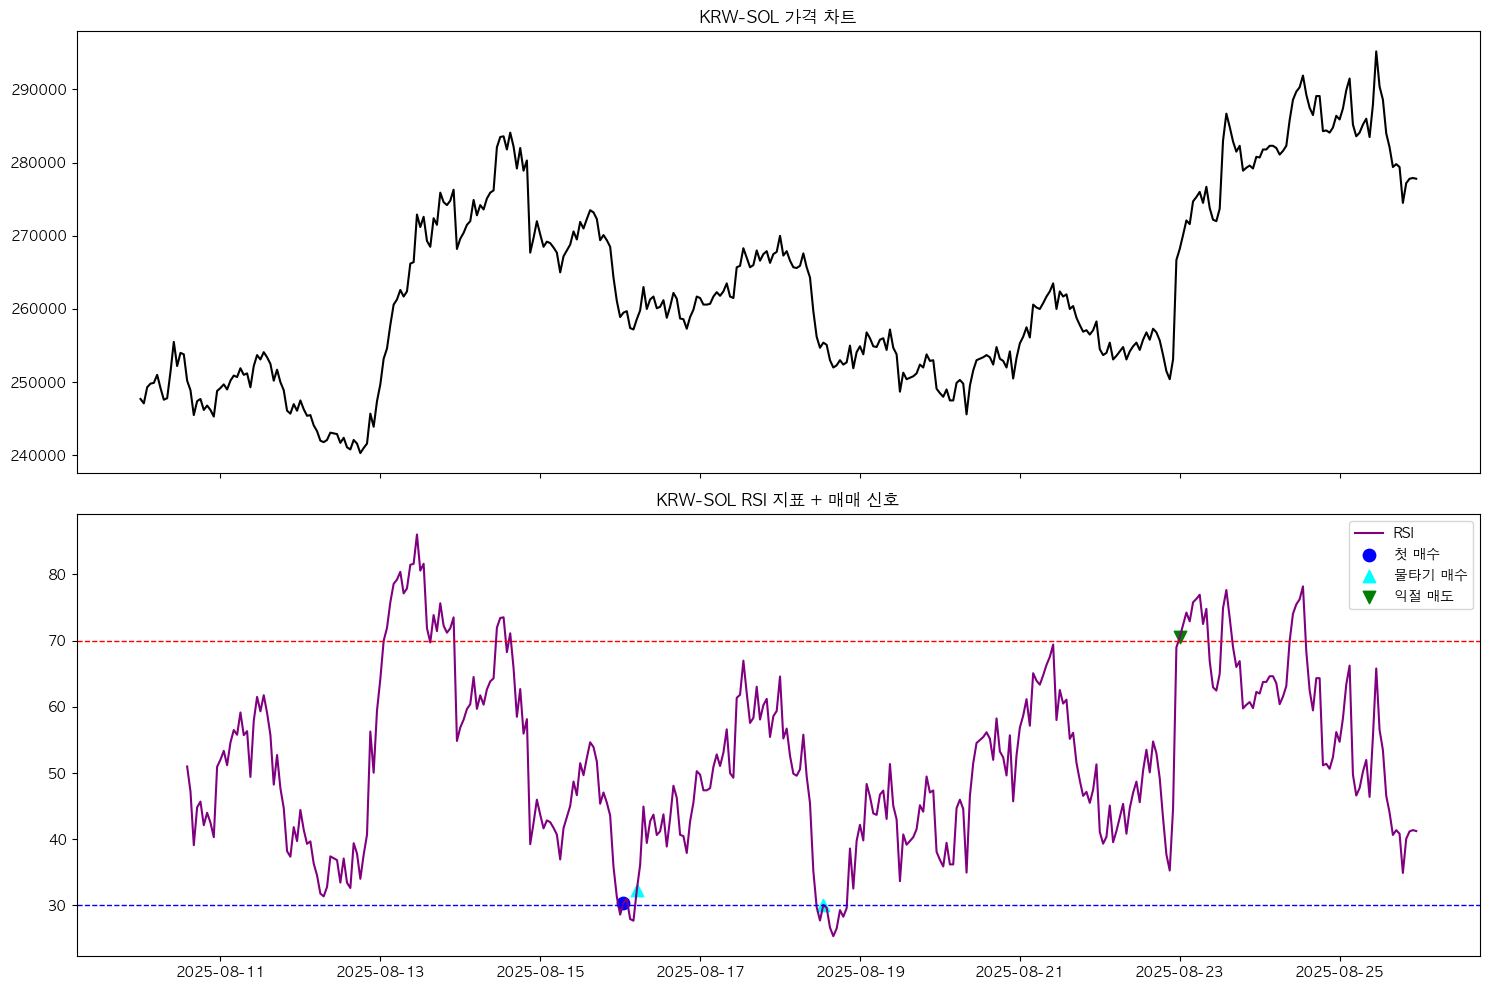

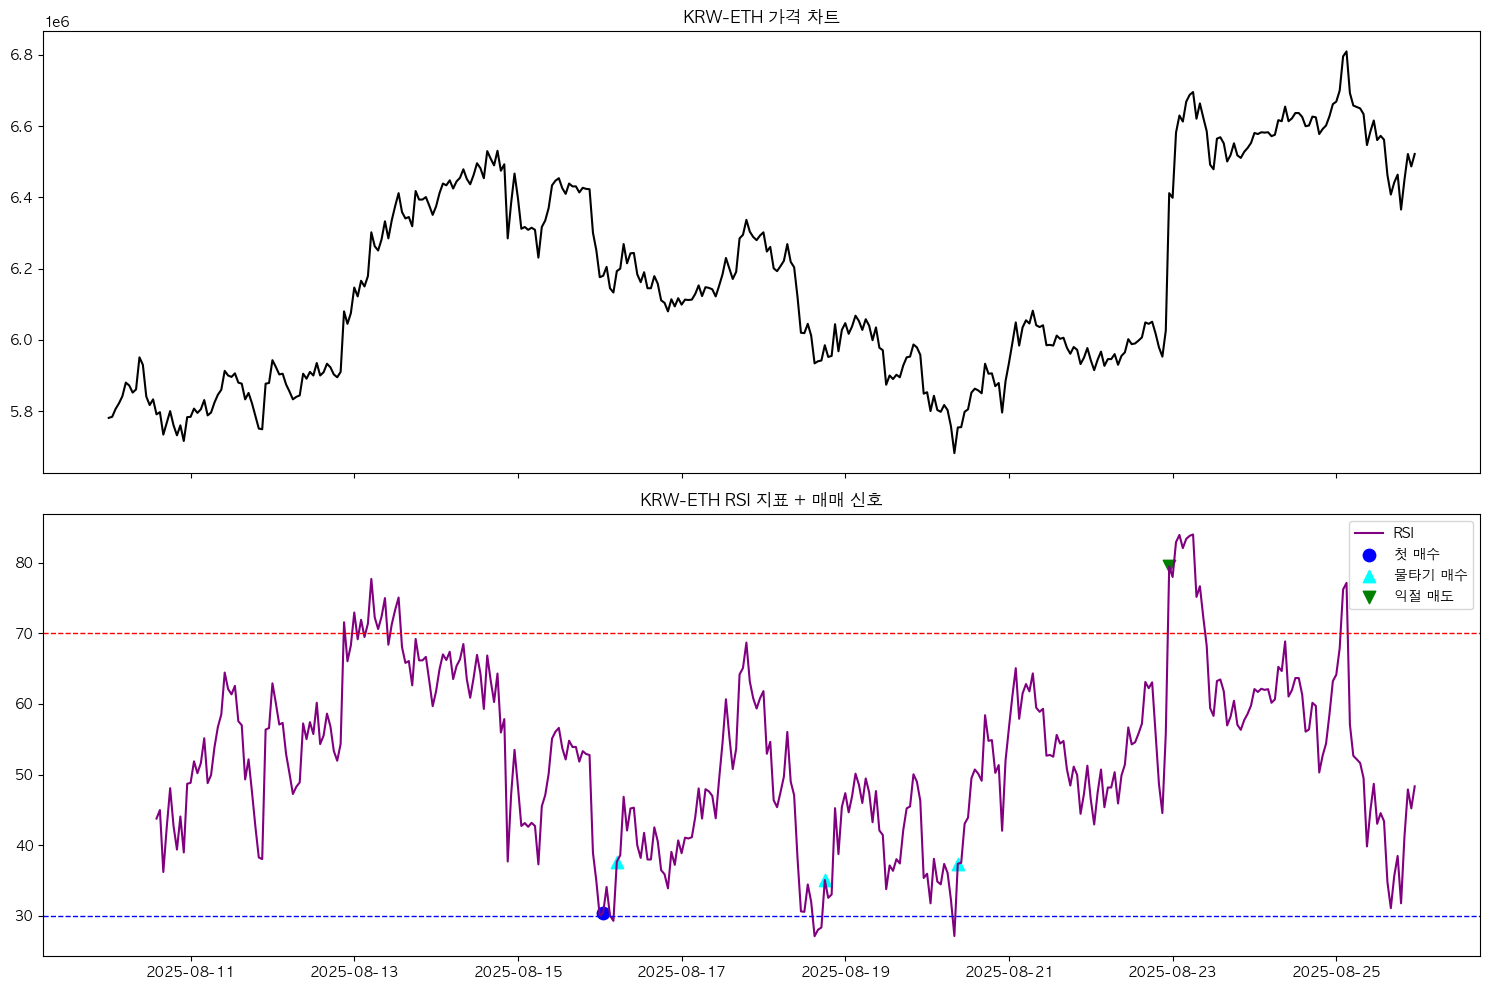

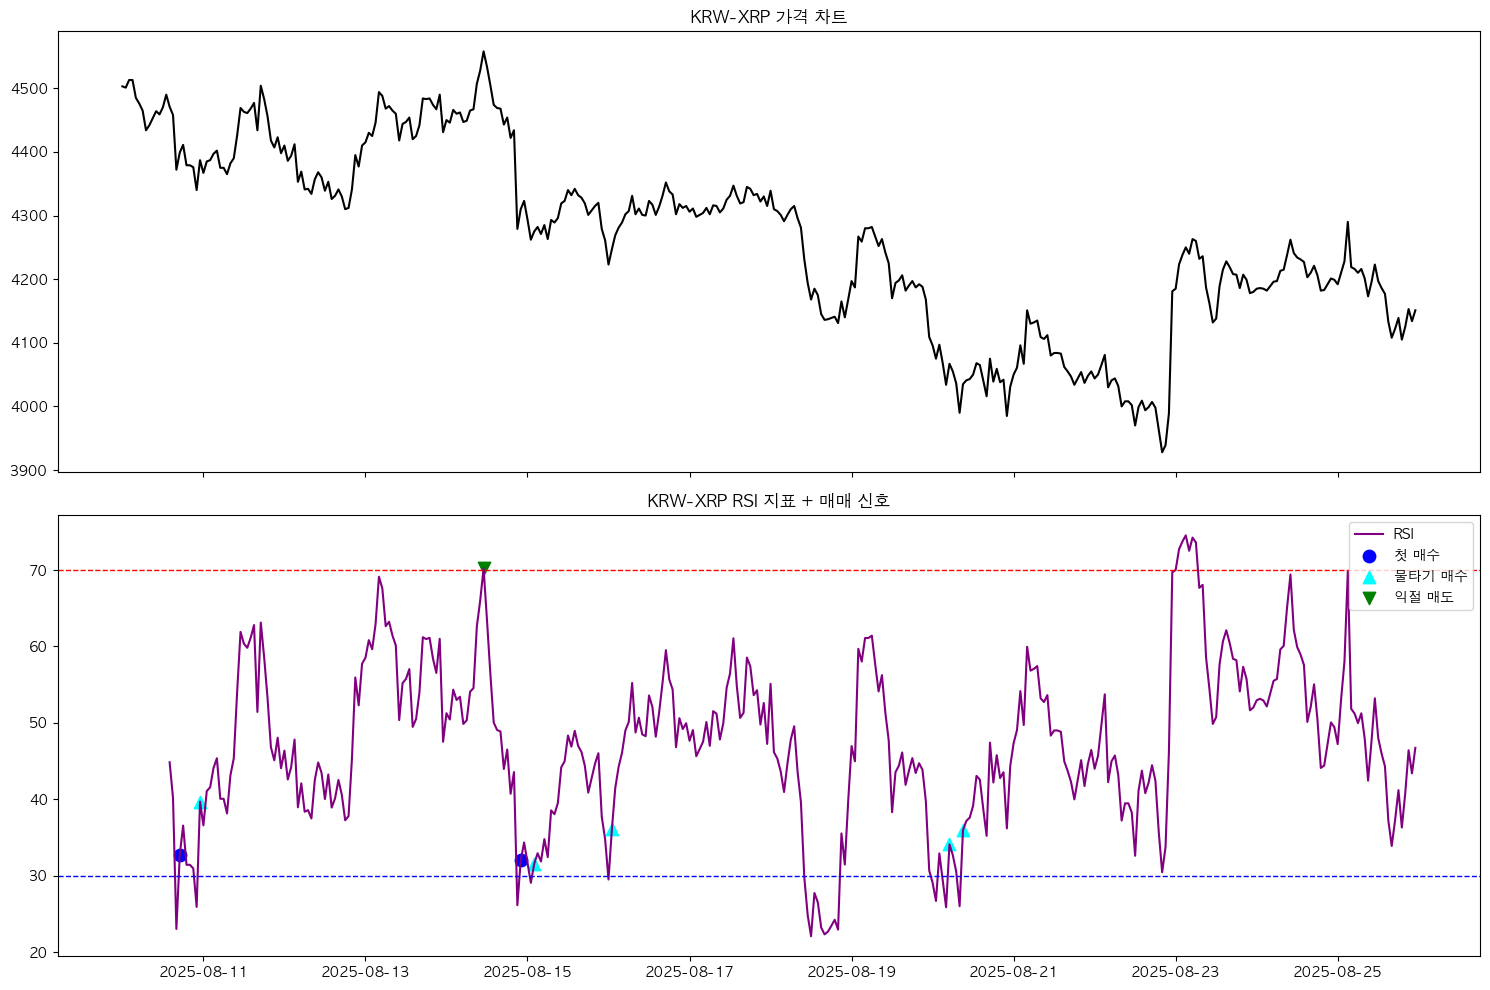

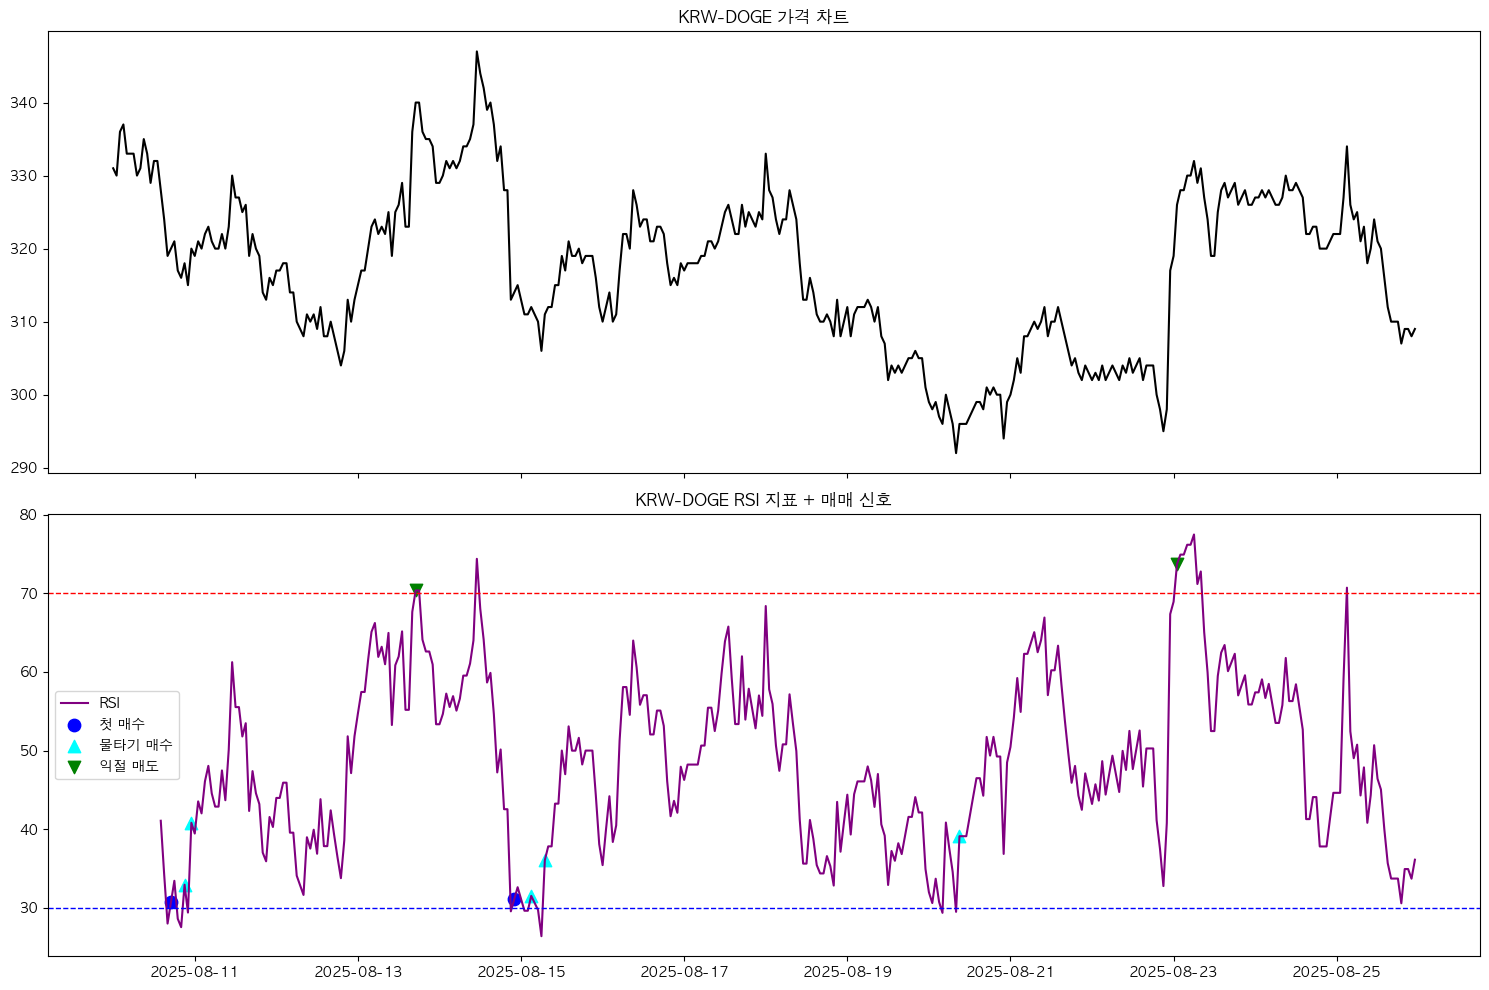

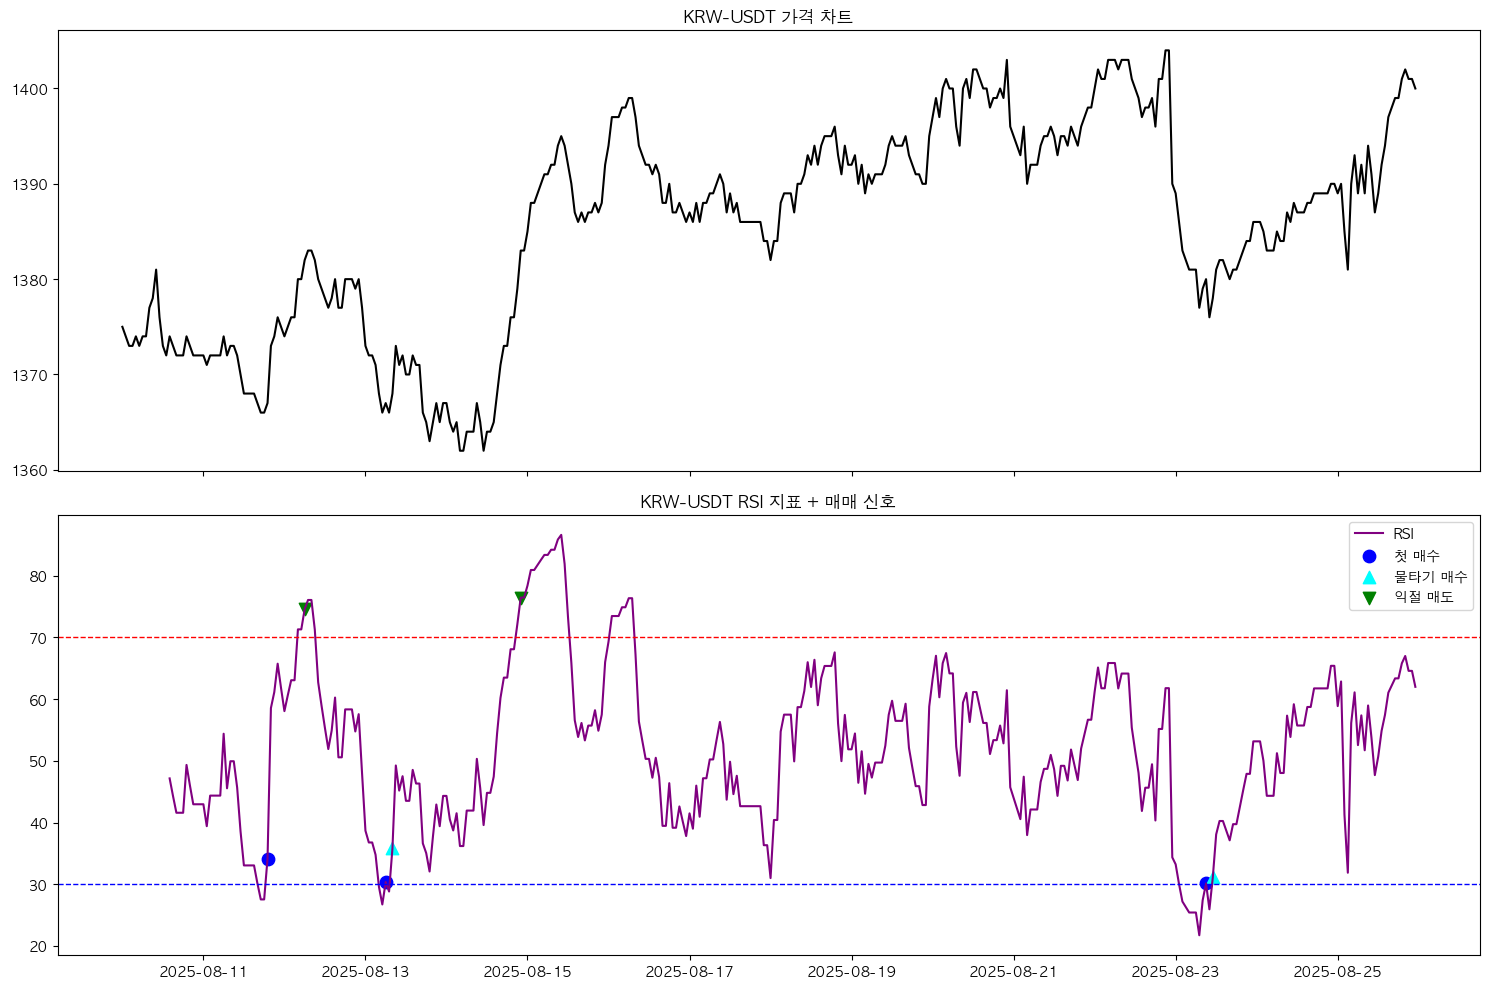

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# =================== Ï∞®Ìä∏ Ï∂úÎ†• ===================
for ticker, df in dfs.items():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # ‚ë† Í∞ÄÍ≤© Ï∞®Ìä∏
    ax1.plot(df.index, df["close"], label="Ï¢ÖÍ∞Ä", color="black")
    ax1.set_title(f"{ticker} Í∞ÄÍ≤© Ï∞®Ìä∏")

    # ‚ë° RSI Ï∞®Ìä∏
    ax2.plot(df.index, df["RSI"], label="RSI", color="purple")
    ax2.axhline(30, color="blue", linestyle="--", linewidth=1)
    ax2.axhline(70, color="red", linestyle="--", linewidth=1)
    ax2.set_title(f"{ticker} RSI ÏßÄÌëú + Îß§Îß§ Ïã†Ìò∏")

    # Ìï¥Îãπ ÏΩîÏù∏ Î°úÍ∑∏Îßå ÌïÑÌÑ∞ÎßÅ
    history = [(time, act, price, note) for time, t, act, price, qty, krw, note in account.all_history if t == ticker]

    # Ïã†Ìò∏Î≥Ñ Î∂ÑÎ•ò
    buys_first = [t for t, act, _, note in history if act == "BUY" and note == "BUY-NEW"]
    buys_water = [t for t, act, _, note in history if act == "BUY" and "WATER" in note]
    sells_profit = [t for t, act, _, note in history if act == "SELL" and "PROFIT" in note]
    sells_loss = [t for t, act, _, note in history if act == "SELL" and "LOSS" in note]

    # RSI ÏúÑÏóê Ï†êÏ∞çÍ∏∞
    if buys_first:
        x = [t for t in buys_first if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="blue", marker="o", s=80, label="Ï≤´ Îß§Ïàò")

    if buys_water:
        x = [t for t in buys_water if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="cyan", marker="^", s=80, label="Î¨ºÌÉÄÍ∏∞ Îß§Ïàò")

    if sells_profit:
        x = [t for t in sells_profit if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="green", marker="v", s=80, label="ÏùµÏ†à Îß§ÎèÑ")

    if sells_loss:
        x = [t for t in sells_loss if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="red", marker="x", s=80, label="ÏÜêÏ†à Îß§ÎèÑ")

    ax2.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# =================== Ï∞®Ìä∏ Ï∂úÎ†• ===================
for ticker, df in dfs.items():
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # ‚ë† Í∞ÄÍ≤© Ï∞®Ìä∏
    ax1.plot(df.index, df["close"], label="Ï¢ÖÍ∞Ä", color="black")
    ax1.set_title(f"{ticker} Í∞ÄÍ≤© Ï∞®Ìä∏")

    # ‚ë° RSI Ï∞®Ìä∏
    ax2.plot(df.index, df["RSI"], label="RSI", color="purple")
    ax2.axhline(30, color="blue", linestyle="--", linewidth=1)
    ax2.axhline(70, color="red", linestyle="--", linewidth=1)
    ax2.set_title(f"{ticker} RSI ÏßÄÌëú + Îß§Îß§ Ïã†Ìò∏")

    # Ìï¥Îãπ ÏΩîÏù∏ Î°úÍ∑∏Îßå ÌïÑÌÑ∞ÎßÅ
    history = [(time, act, price, note) for time, t, act, price, qty, krw, note in account.all_history if t == ticker]

    # Ïã†Ìò∏Î≥Ñ Î∂ÑÎ•ò
    buys_first = [t for t, act, _, note in history if act == "BUY" and note == "BUY-NEW"]
    buys_water = [t for t, act, _, note in history if act == "BUY" and "WATER" in note]
    sells_profit_all = [t for t, act, _, note in history if act == "SELL" and "PROFIT-ALL" in note]
    sells_profit_half = [t for t, act, _, note in history if act == "SELL" and "PROFIT-HALF" in note]
    sells_loss_half = [t for t, act, _, note in history if act == "SELL" and "LOSS-HALF" in note]

    # RSI ÏúÑÏóê Ï†êÏ∞çÍ∏∞
    if buys_first:
        x = [t for t in buys_first if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="blue", marker="o", s=80, label="Ï≤´ Îß§Ïàò")

    if buys_water:
        x = [t for t in buys_water if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="cyan", marker="^", s=80, label="Î¨ºÌÉÄÍ∏∞ Îß§Ïàò")

    if sells_profit_all:
        x = [t for t in sells_profit_all if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="green", marker="s", s=100, label="ÏùµÏ†à Ï†ÑÏ≤¥Îß§ÎèÑ")  # ‚ñ† ÎÑ§Î™®

    if sells_profit_half:
        x = [t for t in sells_profit_half if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="green", marker="v", s=80, label="ÏùµÏ†à Ï†àÎ∞òÎß§ÎèÑ")  # ‚ñº ÏÇºÍ∞ÅÌòï

    if sells_loss_half:
        x = [t for t in sells_loss_half if t in df.index]
        y = [df.loc[t, "RSI"] for t in x]
        ax2.scatter(x, y, color="red", marker="x", s=100, label="ÏÜêÏ†à Ï†àÎ∞òÎß§ÎèÑ")  # ‚úñ XÌëú

    ax2.legend()
    plt.tight_layout()
    plt.show()
